In [1]:
import os
import numpy as np 
import torch
from torch import nn
from torch.nn import functional as F 
import torch.utils.data as td
import torchvision as tv
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import sys

In [2]:
mod1 = torch.load(sys.path[0]+'/../../models/ctdet_coco_resdcn18.pth')

In [3]:
import os
import sys
sys.path.append(sys.path[0]+'/../lib') # Add library folder
from opts import opts
from datasets.dataset_factory import get_dataset
from datasets.dataset.coco import COCO
from datasets.sample.ctdet import CTDetDataset
from trains.ctdet import CtdetTrainer
from trains.train_factory import train_factory

In [4]:
Dataset = get_dataset('coco', 'ctdet')
sys.path.append(sys.path[0]+'/../project_tools')
from fcn_opts import fcn_opts
opt = fcn_opts(Dataset)
opt.down_ratio = 2

In [5]:
dataset = Dataset(opt,'train')
valset = Dataset(opt, 'val')

==> initializing coco 2017 train data.
loading annotations into memory...
Done (t=14.27s)
creating index...
index created!
Loaded train 118287 samples
==> initializing coco 2017 val data.
loading annotations into memory...
Done (t=0.44s)
creating index...
index created!
Loaded val 5000 samples


In [6]:
all_Ids=dataset.coco.getImgIds()
print(len(all_Ids))
import skimage.io as io
img_dir='~/MoDL_CenterNet/data/coco/train2017/'

118287


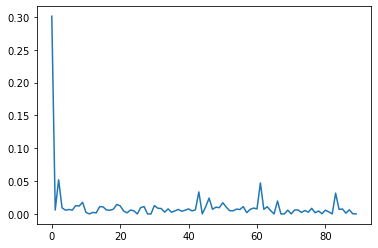

In [7]:
N=2048
import random
np.random.seed(0)
numsets=1
for iter in range(numsets):
    imgIds_perm=np.random.permutation(len(all_Ids))
    tmp=imgIds_perm[0:N].astype(int)
    tmp2=[all_Ids[t] for t in tmp]
    dataset.images=tmp2
    dataset.num_samples=len(dataset.images)
    sub_inst_cat=np.zeros(90)
    for j in range(N):
        sub_cat_lab=[]
        img = dataset.coco.loadImgs(dataset.images[j])[0]
        f_name=img_dir
        f_name+=img['file_name']
        annIds = dataset.coco.getAnnIds(imgIds=img['id'])
        anns = dataset.coco.loadAnns(annIds)
        sub_cat_lab=[k['category_id'] for k in anns]
        for jj in range(90):
            t=np.where(np.asarray(sub_cat_lab)==jj)
            sub_inst_cat[jj-1]+=t[0].shape[0]
    prob_sub=(sub_inst_cat+1)/np.sum(sub_inst_cat+1)    
    plt.plot(sub_inst_cat/(np.sum(sub_inst_cat)))
np.random.seed(2)

input
hm
reg_mask
ind
wh
reg


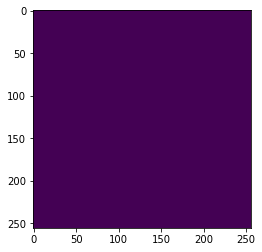

In [8]:
x1=dataset.__getitem__(0)
for key in x1:
    print(key)
plt.imshow(x1['hm'][3,:,:])
plt.show()
#print(x1['ind'],x1['reg_mask'],x1['reg'])

In [9]:
import cv2
def myimshow(image, ax=plt):
    #image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    #image=np.int(((image-np.min(image))/(np.max(image)-np.min(image)))*255)
    #print(image.shape)
    
    h = ax.imshow(image)
    ax.axis('off')
    return h

input
hm
reg_mask
ind
wh
reg


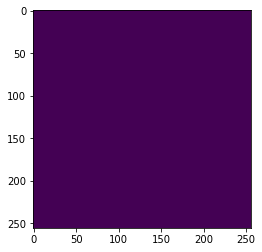

In [10]:
x1=dataset.__getitem__(0)
for key in x1:
    print(key)
plt.imshow(x1['hm'][3,:,:])
plt.show()

In [11]:
sys.path.append(sys.path[0]+'/../lib/models/networks/DCNv2')
from models.model import create_model, load_model, save_model
from trains.ctdet import CtdetTrainer

In [12]:
model = create_model(opt.arch, opt.heads, opt.head_conv)
optimizer = torch.optim.Adam(model.parameters(), opt.lr)

=> loading pretrained model https://download.pytorch.org/models/resnet18-5c106cde.pth
=> init deconv weights from normal distribution


In [13]:
sys.path.append(sys.path[0]+"/../project_tools")
import nntools as nt

In [14]:
class Centernet_model(nt.NeuralNetwork,CtdetTrainer):
    def __init__(self,opt,model,optimizer=None,FineTune=True):
        nt.NeuralNetwork.__init__(self)
        CtdetTrainer.__init__(self,opt,model,optimizer=None)
        if FineTune:
            for name,param in model.named_parameters():
               if name[0:2]=='hm' or name[0:2]=='re' or name[0:2]=='wh':
                    param.data = 0.1*torch.randn(param.size()) # Random initialization
               else: 
                    param.requires_grad=False
            #print(name,param.requires_grad)
        self.model=model
        self.opt=opt
    def forward(self,x):
        m= torch.nn.Upsample(scale_factor=2, mode='nearest')
        x = m(x)
        return self.model(x)
    def criterion(self, y, d):
        return self.loss(y,d)

In [ ]:
model1 =load_model(model,sys.path[0]+'/../../models/ctdet_coco_resdcn18.pth');
net = Centernet_model(opt,model1);
net = net.to(opt.device)
train_loader = td.DataLoader(
      dataset, 
      batch_size=opt.batch_size, 
      shuffle=True,
      num_workers=opt.num_workers,
      pin_memory=True,
      drop_last=True
  )

In [ ]:
adam = torch.optim.Adam(net.parameters(), lr=opt.lr)
stats_manager = nt.StatsManager()
exp2 = nt.Experiment(net,dataset,valset,adam,stats_manager,
output_dir="Experiment_upsamp", batch_size=opt.batch_size,perform_validation_during_training=False)

In [ ]:
exp2.run3(num_epochs=131)

In [ ]:
print(exp2.history)
plt.plot(exp2.history)
plt.show()

In [ ]:
exp2.evaluate2()

In [ ]:
import sys
sys.path.append(sys.path[0]+'/../lib/models/networks/DCNv2')
from detectors.ctdet import CtdetDetector

In [ ]:
opt.load_model = sys.path[0]+'/../../models/ctdet_coco_resdcn18.pth'
opt.dataset = 'coco'
opt.debugger_theme = 'white'
opt.flip_test = False
opt.K = 100
opt.nms = False
opt.vis_thresh = 0.3

In [ ]:
detector = CtdetDetector(opt)
detector.model=net.model
detector.model.eval();

In [ ]:
tst_id=40
img_id = valset.images[tst_id]
img_info = valset.coco.loadImgs(ids=[img_id])[0]
img_path = os.path.join(valset.img_dir, img_info['file_name'])
ret = detector.run(img_path)
#results[img_id] = ret['results']

In [ ]:
coco_class_name = [
     'person', 'bicycle', 'car', 'motorcycle', 'airplane',
     'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant',
     'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
     'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack',
     'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
     'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
     'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass',
     'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
     'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
     'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv',
     'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave',
     'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase',
     'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]
import cv2
imgIds_test=np.random.permutation(len(valset))
for tst_id in range(3):
    #print(len(valset))
    tst_id=imgIds_test[tst_id]
    img_id = valset.images[tst_id]
    img_info = valset.coco.loadImgs(ids=[img_id])[0]
    img_path = os.path.join(valset.img_dir, img_info['file_name'])
    ret = detector.run(img_path)
    im_id = valset[tst_id]['meta']['img_id']
    print(im_id)
    img = valset.coco.loadImgs(im_id)[0]
    print(img)
    img_dir='~/Project_folder/MoDL_CenterNet/data/coco/val2017/'
    f_name=img_dir
    f_name+=img['file_name']
    import skimage.io as io
    I = io.imread(f_name)
    show_txt = True
    for c_id in range(80):
        for j in range(ret['results'][c_id+1].shape[0]):
            if ret['results'][c_id+1][j][4]>=opt.vis_thresh:
                bbox = ret['results'][c_id+1][j]
                cv2.rectangle(I, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0,255,0), 2)
                if show_txt:
                    txt = '{}{:.1f}'.format(coco_class_name[c_id], bbox[4]) # text+confidence
                    font = cv2.FONT_HERSHEY_SIMPLEX
                    cat_size = cv2.getTextSize(txt, font, 0.5, 2)[0]
                    cv2.rectangle(I, (bbox[0], int(bbox[1] - cat_size[1] - 2)),(int(bbox[0] + cat_size[0]), int(bbox[1] - 2)), (0,255,0), -1)
                    cv2.putText(I, txt, (bbox[0], int(bbox[1] - 2)), font, 0.5, (0, 0, 0),thickness=1, lineType=cv2.LINE_AA)


    fig, axes = plt.subplots(figsize=(13,13))
    axes.imshow(I)

In [ ]:
valset = Dataset(opt, 'val')
results = {}
for tst_id in range(len(valset)):
    if np.mod(tst_id,100)==0:
        print(tst_id)
    img_id = valset.images[tst_id]
    img_info = valset.coco.loadImgs(ids=[img_id])[0]
    img_path = os.path.join(valset.img_dir, img_info['file_name'])
    ret = detector.run(img_path)
    results[img_id] = ret['results']

In [ ]:
import sys
opt.save_dir = sys.path[0]+'/results_weighted_l1'
valset.run_eval(results, opt.save_dir)

In [ ]:
import cv2
import skimage.io as io
img_dir=sys.path[0]+'/../../data/coco/val2017/'
num_cols = 1
P=4
fig, axes = plt.subplots(ncols=num_cols, nrows=int(P/num_cols), figsize=(20,300))
show_txt = True

coco_class_name = [
     'person', 'bicycle', 'car', 'motorcycle', 'airplane',
     'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant',
     'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
     'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack',
     'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
     'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
     'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass',
     'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
     'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
     'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv',
     'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave',
     'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase',
     'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]



for ind in range(P):
    img_id = valset.images[ind]
    im_id = img_id
    img = valset.coco.loadImgs(im_id)[0]
    f_name=img_dir
    f_name+=img['file_name']
    I = io.imread(f_name)
    for c_id in range(80):
        for j in range(results[img_id][c_id+1].shape[0]):
            if results[img_id][c_id+1][j][4]>=opt.vis_thresh:
                bbox = results[img_id][c_id+1][j]
                cv2.rectangle(I, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0,255,0), 2)
                if show_txt:
                    txt = '{}{:.1f}'.format(coco_class_name[c_id], bbox[4]) # text+confidence
                    font = cv2.FONT_HERSHEY_SIMPLEX
                    cat_size = cv2.getTextSize(txt, font, 0.5, 2)[0]
                    cv2.rectangle(I, (bbox[0], int(bbox[1] - cat_size[1] - 2)),
                                  (int(bbox[0] + cat_size[0]), int(bbox[1] - 2)), (0,255,0), -1)
                    cv2.putText(I, txt, (bbox[0], int(bbox[1] - 2)), 
                                font, 0.5, (0, 0, 0),thickness=1, lineType=cv2.LINE_AA)
    axes[ind].imshow(I)

In [15]:
model1 =load_model(model,sys.path[0]+'/../../models/ctdet_coco_resdcn18.pth');
net2 = Centernet_model(opt,model1);
net2 = net2.to(opt.device)

loaded /datasets/home/home-01/30/230/psarangi/Project_folder/MoDL_CenterNet/src/local_notebooks/../../models/ctdet_coco_resdcn18.pth, epoch 140


In [16]:
adam2 = torch.optim.Adam(net2.parameters(), lr=opt.lr)
stats_manager2 = nt.StatsManager()
exp3 = nt.Experiment(net2,dataset,valset,adam2,stats_manager2,
output_dir="Experiment_upsamp2", batch_size=opt.batch_size,perform_validation_during_training=False)

In [ ]:
exp3.run2(num_epochs=200)

Start/Continue training from epoch 189


/opt/conda/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 190 (Time: 341.34s)
Epoch 191 (Time: 348.83s)


[106146.30799865723, 9968.95393872261, 1105.768128156662, 389.64595371484756, 195.56460884213448, 124.79224754869938, 83.38787089288235, 60.356928162276745, 45.965759716928005, 37.1572748683393, 29.426678247749805, 25.005173910409212, 21.009001031517982, 18.258600521832705, 16.165540784597397, 14.37302903085947, 12.967196568846703, 12.3289430513978, 11.114059085026383, 10.567030200734735, 10.026816997677088, 9.570481875911355, 9.237826064229012, 8.847785774618387, 8.50560219399631, 8.29979027248919, 8.219234641641378, 7.971679054200649, 7.927929155528545, 7.668537549674511, 7.641935473307967, 7.588002342730761, 7.498138567432761, 7.447322266176343, 7.368695892393589, 7.307987540960312, 7.2840097807347775, 7.199275683611631, 7.158284679055214, 7.093494240194559, 7.0016985554248095, 7.033391255885363, 6.944212945178151, 6.897520674392581, 6.86089457385242, 6.734636617824435, 6.69413560628891, 6.6099505219608545, 6.4773862939327955, 6.333259677514434, 6.311868514865637, 6.2685008104890585

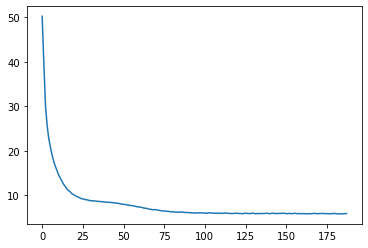

In [17]:
print(exp3.history)
plt.plot(10*np.log10(exp3.history))
plt.show()

In [18]:
import sys
sys.path.append(sys.path[0]+'/../lib/models/networks/DCNv2')
from detectors.ctdet import CtdetDetector

In [19]:
opt.load_model = sys.path[0]+'/../../models/ctdet_coco_resdcn18.pth'
opt.dataset = 'coco'
opt.debugger_theme = 'white'
opt.flip_test = False
opt.K = 100
opt.nms = False
opt.vis_thresh = 0.3

In [20]:
detector = CtdetDetector(opt)
detector.model=net2
detector.model.eval();

Creating model...
=> loading pretrained model https://download.pytorch.org/models/resnet18-5c106cde.pth
=> init deconv weights from normal distribution
loaded /datasets/home/home-01/30/230/psarangi/Project_folder/MoDL_CenterNet/src/local_notebooks/../../models/ctdet_coco_resdcn18.pth, epoch 140


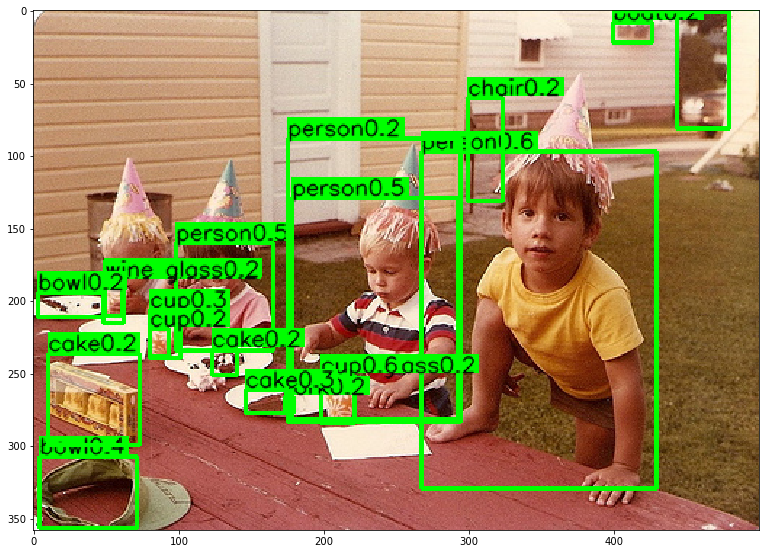

In [21]:
coco_class_name = [
     'person', 'bicycle', 'car', 'motorcycle', 'airplane',
     'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant',
     'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
     'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack',
     'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
     'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
     'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass',
     'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
     'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
     'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv',
     'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave',
     'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase',
     'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]
import cv2
imgIds_test=np.random.permutation(len(valset))
for tst_id in range(1):
    #print(len(valset))
    tst_id=imgIds_test[tst_id]
    img_id = valset.images[tst_id]
    #img_id = 259261
    img_info = valset.coco.loadImgs(ids=[img_id])[0]
    img_path = os.path.join(valset.img_dir, img_info['file_name'])
    ret = detector.run(img_path)
    #print(ret['results'])
    im_id = valset[tst_id]['meta']['img_id']
    im_id = img_id
    #print(im_id)
    img = valset.coco.loadImgs(im_id)[0]
    #print(img)
    img_dir='~/Project_folder/MoDL_CenterNet/data/coco/val2017/'
    f_name=img_dir
    f_name+=img['file_name']
    import skimage.io as io
    I = io.imread(f_name)
    show_txt = True
    for c_id in range(80):
        for j in range(ret['results'][c_id+1].shape[0]):
            if ret['results'][c_id+1][j][4]>=opt.vis_thresh*2/3:
                bbox = ret['results'][c_id+1][j]
                cv2.rectangle(I, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0,255,0), 2)
                if show_txt:
                    txt = '{}{:.1f}'.format(coco_class_name[c_id], bbox[4]) # text+confidence
                    font = cv2.FONT_HERSHEY_SIMPLEX
                    cat_size = cv2.getTextSize(txt, font, 0.5, 2)[0]
                    cv2.rectangle(I, (bbox[0], int(bbox[1] - cat_size[1] - 2)),(int(bbox[0] + cat_size[0]), int(bbox[1] - 2)), (0,255,0), -1)
                    cv2.putText(I, txt, (bbox[0], int(bbox[1] - 2)), font, 0.5, (0, 0, 0),thickness=1, lineType=cv2.LINE_AA)


    fig, axes = plt.subplots(figsize=(13,13))
    axes.imshow(I)

In [22]:
img_id

345361

In [23]:
valset = Dataset(opt, 'val')
results = {}
for tst_id in range(len(valset)):
    if np.mod(tst_id,100)==0:
        print(tst_id)
    img_id = valset.images[tst_id]
    img_info = valset.coco.loadImgs(ids=[img_id])[0]
    img_path = os.path.join(valset.img_dir, img_info['file_name'])
    ret = detector.run(img_path)
    results[img_id] = ret['results']

==> initializing coco 2017 val data.
loading annotations into memory...
Done (t=0.58s)
creating index...
index created!
Loaded val 5000 samples
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


In [24]:
import sys
opt.save_dir = sys.path[0]+'/results_upsamp'
valset.run_eval(results, opt.save_dir)

Loading and preparing results...
DONE (t=6.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=63.08s).
Accumulating evaluation results...
DONE (t=10.37s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.154
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.268
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.158
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.098
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.244
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.144
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.183
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.327
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.367
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=